In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
from matplotlib import rc, gridspec
import keras_tuner as kt
import pickle
import seaborn as sns
import scipy
import tensorflow_probability as tfp 
import statsmodels.api as sm
from tqdm import tqdm

from utils.ml_models import SOHyperModel
from utils.stochastic_processes import SOPowerStep
from utils.power_functions import FourSteps
from utils.ml_models import DailyProfileModel, ConstantModel
from utils import data_prep


custom_dtype='float64'
tf.keras.backend.set_floatx(custom_dtype)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Setup

In [ ]:
# Setup folder(s)
version= '2023-05-03'
    
# Define loss
def negloglik(p, rv_p):
    return -rv_p.log_prob(p)
  
# Prepare target/feature data and initial conditions Z
freq, features = data_prep.load_data()
ts, dfs = data_prep.prepare_data(freq, features, custom_dtype=custom_dtype) 


day_ahead_cols = dfs['X_train'].filter(regex='day_ahead|hour|minute').columns # day-ahead forecasts and hour
expost_cols = dfs['X_train'].drop(columns=day_ahead_cols).columns.append(pd.Index(['prices_day_ahead'])) # only ex-post and prices

dp_model = DailyProfileModel()
c_model = ConstantModel()

model_dir = './results/CE/version_{}'.format(version)+'/{}/'

In [3]:
model_display_names = {'c_model':'Constant', 'dp_model':'Daily profile', 'day_ahead':'Day-ahead', 'ex_post':'Ex-post'}
param_display_names_units = {'tau':'Primary control \ntime scale $\\tau$ [s]', 'kappa':'Intrinsic secondary control \ntime scale $\kappa$ [s]',
                             'D':'Power fluctuation \nstrength $D$ [s$^{-3/2}$]', 'q1':'Power step $q_1$ [s$^{-1}$]', 'r':'Power drift $r$ [s$^{-2}$]'}
param_display_names = {'tau':r'Primary control time scale $\tau$', 'kappa':'Intrinsic secondary control time scale $\kappa$', 'D':'Power fluctuation strength $D$',
                       'q1':'Power step $q_1$', 'r':'Power drift $r$'}
param_display_names_short = {'tau':r'$\tau$ [s]', 'kappa':'$\kappa$ [s]', 'D':'$D$ [s$^{-3/2}$]', 'q1':'$q_1$ [s$^{-1}$]', 'r':'$r$ [s$^{-2}$]'}
param_display_names_abs = {'tau':r'$\tau$', 'kappa':'$\kappa$', 'D':'$D$', 'q1':'$|q_1|$', 'r':'$|r|$'}

param_rescaling = {'tau':1., 'kappa':1., 'D':1, 'q1':1, 'r':1} 

param_names_short = ['s_theta_0','cov_theta_omega_0', 's_omega_0', # 0-4 is y0
                            'tau', 'kappa', 'D', 'q1', 'r'] 
param_names = ['s_theta_0','cov_theta_omega_0', 's_omega_0', # 0-4 is y0
                            'tau', 'kappa', 'D', 'q1', 'q2', 'q3', 'q4', 'r'] 

In [4]:
c_post, c_const, c_dp,c_data,c_q, c_tau, c_kappa, c_D,c_dh , c_r = sns.color_palette("colorblind", 10)

model_colors = {'Constant':c_const, 'Daily profile':c_dp, 'Day-ahead':c_dh, 'Ex-post':c_post}
param_colors = {'tau':c_tau, 'kappa':c_kappa, 'D':c_D, 'q1':c_q, 'r':c_r} 

In [5]:
input_cols = ['gen_other', 'gen_solar', 'gen_wind_on', 'gen_waste', 'gen_nuclear',
       'gen_biomass', 'gen_gas', 'gen_run_off_hydro', 'gen_oil',
       'gen_pumped_hydro', 'gen_other_renew', 'gen_reservoir_hydro',
       'gen_hard_coal', 'gen_wind_off', 'gen_geothermal', 'gen_lignite',
       'load', 'gen_coal_gas', 'total_gen', 'synchronous_gen', 'load_ramp',
       'total_gen_ramp', 'other_ramp', 'solar_ramp', 'wind_on_ramp',
       'waste_ramp', 'nuclear_ramp', 'biomass_ramp', 'gas_ramp',
       'run_off_hydro_ramp', 'oil_ramp', 'pumped_hydro_ramp',
       'other_renew_ramp', 'reservoir_hydro_ramp', 'hard_coal_ramp',
       'wind_off_ramp', 'geothermal_ramp', 'lignite_ramp', 'coal_gas_ramp',
       'forecast_error_wind_on', 'forecast_error_wind_off',
       'forecast_error_solar', 'forecast_error_total_gen',
       'forecast_error_load', 'forecast_error_load_ramp',
       'forecast_error_total_gen_ramp', 'forecast_error_wind_off_ramp',
       'forecast_error_wind_on_ramp', 'forecast_error_solar_ramp',
       'solar_day_ahead', 'wind_on_day_ahead', 'scheduled_gen_total',
       'prices_day_ahead', 'load_day_ahead', 'wind_off_day_ahead', 'month',
       'weekday', 'hour', 'load_ramp_day_ahead', 'total_gen_ramp_day_ahead',
       'wind_off_ramp_day_ahead', 'wind_on_ramp_day_ahead',
       'solar_ramp_day_ahead', 'price_ramp_day_ahead','gen_fossil_peat','fossil_peat_ramp',
       'hour_cos', 'hour_sin', 'minute_cos', 'minute_sin',
       'residual']


input_col_names = ['Generation other', 'Solar generation', 'Onshore wind generation', 'Waste generation', 'Nuclear generation',
       'Biomass generation', 'Gas generation', 'Run-off-river hydro generation', 'Oil generation',
       'Pumped hydro generation', 'Other renewable generation', 'Reservoir hydro generation',
       'Hard coal generation', 'Wind offshore generation', 'Geothermal generation', 'Lignite generation',
       'Load', 'Coal gas generation', 'Total generation', 'Synchronous generation', 'Load ramp',
       'Total generation ramp', 'Other ramp', 'Solar ramp', 'Onshore wind ramp',
       'Waste ramp', 'Nuclear ramp', 'Biomass ramp', 'Gas ramp',
       'Run-off-river hydro ramp', 'Oil ramp', 'Pumped hydro ramp',
       'Other renewable ramp', 'Reservoir hydro ramp', 'Hard coal ramp',
       'Offshore wind ramp', 'geothermal_ramp', 'Lignite ramp', 'Coal gas ramp',
       'Forecast error onshore wind', 'Forecast error offshore wind',
       'Forecast error solar', 'Forecast error total generation',
       'Forecast error load', 'Forecast error load ramp',
       'Forecast error generation ramp', 'Forecast error offshore wind ramp',
       'Forecast error onshore wind ramp', 'Forecast error solar ramp',
       'Solar day-ahead', 'Onshore wind day-ahead', 'Scheduled generation',
       'Prices day-ahead', 'Load day-ahead', 'Offshore wind day-ahead', 'Month',
       'Weekday', 'Hour', 'Load ramp day-ahead', 'Generation ramp day-ahead',
       'Offshore wind ramp day-ahead', 'Onshore wind ramp day-ahead',
       'Solar ramp day-ahead', 'Price ramp day-ahead', 'Fossil peat generation', 'Fossil peat ramp',
       'cos(hour)', 'sin(hour)', 'cos(minute)', 'sin(minute)',
       'Residual']

#Remark: The unit for prices varies among the areas. Here, we only display GB price data and thus use £ as a unit for simplicity.
# "input_col_names_units_general" contains the general unit of "currency" instead. 
input_col_names_units = ['Generation other [GW]', 'Solar generation [GW]', 'Onshore wind \ngeneration [GW]', 'Waste generation [GW]',
                         'Nuclear generation [GW]',
       'Biomass generation [GW]', 'Gas generation [GW]', 'Run-off-river \nhydro generation [GW]', 'Oil generation [GW]',
       'Pumped hydro \ngeneration [GW]', 'Other renewable generation [GW]', 'Reservoir \nhydro generation [GW]',
       'Hard coal \ngeneration [GW]', 'Wind offshore \ngeneration [GW]', 'Geothermal generation [GW]', 'Lignite generation [GW]',
       'Load [GW]', 'Coal gas generation [GW]', 'Total generation [GW]', 'Synchronous generation [GW]', 'Load ramp [GW/h]',
       'Total generation \nramp [GW/h]', 'Other ramp [GW/h]', 'Solar ramp [GW/h]', 'Onshore wind ramp [GW/h]',
       'Waste ramp [GW/h]', 'Nuclear ramp [GW/h]', 'Biomass ramp [GW/h]', 'Gas ramp [GW/h]',
       'Run-off-river \nhydro ramp [GW/h]', 'Oil ramp [GW/h]', 'Pumped hydro \nramp [GW/h]',
       'Other renewables ramp [GW/h]', 'Reservoir hydro \nramp [GW/h]', 'Hard coal \nramp [GW/h]',
       'Offshore wind ramp [GW/h]', 'geothermal_ramp [GW/h]', 'Lignite ramp [GW/h]', 'coal_gas_ramp [GW/h]',
       'Forecast error \nonshore wind [GW]', 'Forecast error \noffshore wind [GW]',
       'Forecast error \nsolar [GW]', 'Forecast error \ntotal generation [GW]',
       'Forecast error load [GW]', 'Forecast error \nload ramp [GW]',
       'Forecast error \ngeneration ramp [GW/h]', 'Forecast error \noffshore wind ramp [GW/h]',
       'Forecast error \nonshore wind ramp [GW/h]', 'Forecast error \nsolar ramp [GW/h]',
       'Solar day-ahead [GW]', 'Onshore wind \nday-ahead [GW]', 'Scheduled \ngeneration [GW]',
       'Prices day-ahead [€/MWh]', 'Load day-ahead [GW]', 'Offshore wind \nday-ahead [GW]', 'Month',
       'Weekday', 'Hour', 'Load ramp \nday-ahead [GW/h]', 'Generation ramp \nday-ahead [GW/h]',
       'Offshore wind \nramp day-ahead [GW/h]', 'Onshore wind \nramp day-ahead [GW/h]',
       'Solar ramp \nday-ahead [GW/h]', 'Price ramp \nday-ahead [€/MWh/h]','Fossil peat generation [GW]', 'Fossil peat ramp [GW/h]',
       'cos(hour)', 'sin(hour)', 'cos(minute)', 'sin(minute)',
       'Residual']

input_col_names_units_general = ['Generation other [GW]', 'Solar generation [GW]', 'Onshore wind generation [GW]', 'Waste generation [GW]', 'Nuclear generation [GW]',
       'Biomass generation [GW]', 'Gas generation [GW]', 'Run-off-river hydro generation [GW]', 'Oil generation [GW]',
       'Pumped hydro generation [GW]', 'Other renewable generation [GW]', 'Reservoir hydro generation [GW]',
       'Hard coal generation [GW]', 'Wind offshore generation [GW]', 'Geothermal generation [GW]', 'Lignite generation [GW]',
       'Load [GW]', 'Coal gas generation [GW]', 'Total generation [GW]', 'synchronous_gen [GW]', 'Load ramp [GW/h]',
       'Total generation ramp [GW/h]', 'Other ramp [GW/h]', 'Solar ramp [GW/h]', 'Onshore wind ramp [GW/h]',
       'Waste ramp [GW/h]', 'Nuclear ramp [GW/h]', 'Biomass ramp [GW/h]', 'Gas ramp [GW/h]',
       'Run-off-river hydro ramp [GW/h]', 'Oil ramp [GW/h]', 'Pumped hydro ramp [GW/h]',
       'Other renewables ramp [GW/h]', 'Reservoir hydro ramp [GW/h]', 'Hard coal ramp [GW/h]',
       'Offshore wind ramp [GW/h]', 'geothermal_ramp [GW/h]', 'Lignite ramp [GW/h]', 'coal_gas_ramp [GW/h]',
       'Forecast error onshore wind [GW]', 'Forecast error offshore wind [GW]',
       'Forecast error solar [GW]', 'Forecast error total generation [GW]',
       'Forecast error load [GW]', 'Forecast error load ramp [GW]',
       'Forecast error generation ramp [GW/h]', 'Forecast error offshore wind ramp [GW/h]',
       'Forecast error onshore wind ramp [GW/h]', 'Forecast error solar ramp [GW/h]',
       'Solar day-ahead [GW]', 'Onshore wind day-ahead [GW]', 'Scheduled generation [GW]',
       'Prices day-ahead [Currency/MWh]', 'Load day-ahead [GW]', 'Offshore wind day-ahead [GW]', 'Month',
       'Weekday', 'Hour', 'Load ramp day-ahead [GW/h]', 'Generation ramp day-ahead [GW/h]',
       'Offshore wind ramp day-ahead [GW/h]', 'Onshore wind ramp day-ahead [GW/h]',
       'Solar ramp day-ahead [GW/h]', 'Price ramp day-ahead [Currency/MWh/h]','Fossil peat generation [GW]', 'Fossil peat ramp [GW/h]',
       'cos(hour)', 'sin(hour)', 'cos(minute)', 'sin(minute)',
       'Residual']

input_col_names = dict(zip(input_cols, input_col_names))
input_col_names_units = dict(zip(input_cols, input_col_names_units))
input_col_names_units_general = dict(zip(input_cols, input_col_names_units_general))

input_rescale_factors = pd.Series(index=input_cols, data=1/1000)
input_rescale_factors.loc[['weekday', 'hour','month', 'prices_day_ahead','price_ramp_day_ahead']]=1

# Figure 1

In [26]:
syn_gen = np.zeros(3600+10*60)
syn_gen[:4*60] = 320
syn_gen[4*60:900+4*60] = 300-80
syn_gen[900+4*60:1800+4*60] = 300-80 -15
syn_gen[1800+4*60:2700+4*60] = 300-80 -15-70
syn_gen[2700+4*60:-6*60] = 300-80 -15-70 -15
syn_gen[-6*60:] = 20
syn_gen+= np.sin(np.arange(3600+10*60)*(2*np.pi)/1100)*2
syn_gen = pd.Series(syn_gen)
syn_gen_smooth = pd.Series(syn_gen).rolling(200, min_periods=1, win_type='gaussian', center=True).mean(std=50)

syn_load = np.zeros(3600+10*60)
syn_load[:200] = np.arange(200)*0.07
syn_load[200:900] = syn_load[199]+np.arange(700)*0.1
syn_load[900:1900] = syn_load[899]+np.arange(1000)*0.03
syn_load[1900:2200] = syn_load[1899]+np.arange(300)*0.13
syn_load[2200:] = syn_load[2199]+np.arange(1400+10*60)*0.05
syn_load_smooth = -pd.Series(syn_load-300).rolling(150,min_periods=1, center=True).mean()

sawtooth_model=syn_load_smooth.copy()
sawtooth_model.iloc[:-6*60]=FourSteps(custom_dtype).apply(np.arange(-60*4,3600,1),-75,-25,-60,-25,0.06) +30
sawtooth_model.iloc[-6*60:]=sawtooth_model.iloc[-6*60-1]-100+0.06*np.arange(6*60)


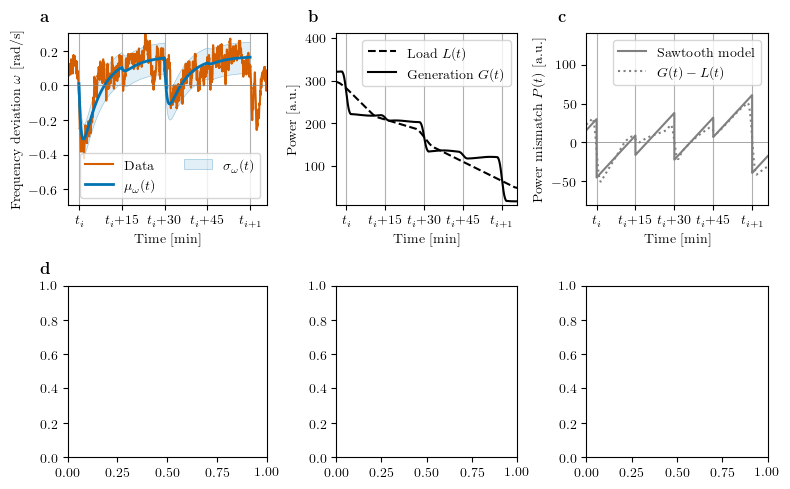

In [27]:
ts = tf.constant(np.arange(0,3600, 1.).astype(custom_dtype))
st_process = SOPowerStep(ts,FourSteps(custom_dtype))

params_mean = [[0.,0.01],40, 130,[-0.01,-0.001,-0.008,-0.00038,0.00001]]
params_sigma = [[0.000001,0.00000001,0.01], 40, 130, 0.02]

fig, axs = plt.subplots(2,3, figsize=(8,5),gridspec_kw={'width_ratios': [1.1,1,1]})
axs[0,0].autoscale(enable=True, axis='x', tight=True)

############################
sol_mean = st_process.mean_t(*params_mean)[0]
sol_sigma = st_process.sigma_t(*params_sigma)[0]

start_date = '2018-11-10'
axs[0,0].plot(np.arange(-60*4,3600+60*6,1), freq.loc[start_date+' 21:56:01':start_date+' 23:06:00'].values, label='Data', c=c_data)
axs[0,0].plot(np.arange(3600), sol_mean, label=r'$\mu_{\omega}(t)$', lw=2, c=c_post)
axs[0,0].axhline(0, color='gray', linewidth=0.5)
axs[0,0].fill_between(np.arange(3600), sol_mean-sol_sigma,sol_mean+sol_sigma, label='$\sigma_{\omega}(t)$', lw=0.5,  
                      facecolor='#0073b01d', edgecolor='#0073b05a')
axs[0, 0].grid(axis='x')
axs[0,0].set_xlabel('Time [min]')
axs[0,0].set_xticks([0,900,1800,2700,3600])
axs[0,0].set_xticklabels([r'$t_i$','$t_i$+15','$t_i$+30','$t_i$+45',r'$t_{i+1}$'])
#axs[k,l].set_ylabel(r'$\omega$ [a.u.]')
axs[0,0].legend( ncol=2, loc='lower right')
axs[0,0].set_ylim([-0.69,0.3])
axs[0,0].set_ylabel('Frequency deviation $\omega$ [rad/s]')

################################

axs[0, 1].grid(axis='x')
axs[0,1].set_xlabel('Time [min]')
axs[0,1].set_xticks([0,900,1800,2700,3600])
axs[0,1].set_xticklabels([r'$t_i$','$t_i$+15','$t_i$+30','$t_i$+45',r'$t_{i+1}$'])
axs[0,1].set_xlim(axs[0,0].get_xlim())
axs[0,1].set_ylim([10,410])
axs[0,1].plot(np.arange(-60*4,3600+60*6,1), syn_load_smooth.values,'--', label='Load $L(t)$', c='k')
axs[0,1].plot(np.arange(-60*4,3600+60*6,1), syn_gen_smooth.values, label='Generation $G(t)$', c='k')
axs[0,1].legend( ncol=1)
axs[0,1].set_ylabel('Power [a.u.]')

axs[0,2].plot(np.arange(-60*4,3600+60*6,1), sawtooth_model.values, label='Sawtooth model', c='gray')
axs[0,2].plot(np.arange(-60*4,3600+60*6,1), (syn_gen_smooth-syn_load_smooth).values,':', label='$G(t)-L(t)$', c='gray')
axs[0, 2].grid(axis='x')
axs[0,2].set_xlabel('Time [min]')
axs[0,2].set_xticks([0,900,1800,2700,3600])
axs[0,2].set_xticklabels([r'$t_i$','$t_i$+15','$t_i$+30','$t_i$+45',r'$t_{i+1}$'])
axs[0,2].set_xlim(axs[0,0].get_xlim())
axs[0,2].legend( ncol=1)
axs[0,2].set_ylabel('Power mismatch $P(t)$ [a.u.]')
axs[0,2].set_ylim([-80,140])
axs[0,2].axhline(0, color='gray', linewidth=0.5)

####################################
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}']
for label, ax in zip(axs_labels, axs.flatten()):
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

plt.tight_layout()
plt.savefig('./figures/fig1_a-d.pdf', bbox_inches='tight')

# Figure 2

In [ ]:
model_names = [ 'c_model','dp_model', 'day_ahead', 'ex_post']
tmax = np.arange(5,60.5,5, dtype=int)*60
perf_logl = pd.DataFrame(index=dfs['y_test'].index,
                         columns=pd.MultiIndex.from_product([model_names, tmax]))


for feature_types, cols in zip(['ex_post', 'day_ahead'], [expost_cols, day_ahead_cols]):
    
    # re-load best model via tuner
    with open(model_dir.format(feature_types)+'fixed_model_hps.pkl', 'rb') as f:
        fixed_model_hps = pickle.load(f)
    tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                    directory=model_dir.format(feature_types), oracle=kt.Oracle(),project_name="tuning")
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.load_weights(model_dir.format(feature_types)+'best_model/').expect_partial()
    print(best_hps.values)

    # Predict means and stddev on test set
    ml_pred_mean = model([dfs['X_test'].loc[:,cols],dfs['Z_test']]).mean()
    ml_pred_stddev = model([dfs['X_test'].loc[:,cols],dfs['Z_test']]).stddev()
 

    for i in range(len(tmax)):
            
        ml_pred_interval_dist = tfp.distributions.MultivariateNormalDiag(loc = ml_pred_mean[:,:tmax[i]],
                                                                         scale_diag = ml_pred_stddev[:,:tmax[i]])
        perf_logl.loc[:,(feature_types, tmax[i])] = negloglik(dfs['y_test'].iloc[:,:tmax[i]],
                                                           ml_pred_interval_dist)


for i in range(len(tmax)):

    dp_model.fit(dfs['y_train'].append(dfs['y_val']).iloc[:,:tmax[i]]) 
    perf_logl.loc[:,('dp_model', tmax[i])] = negloglik(dfs['y_test'].iloc[:,:tmax[i]],
                                                        dp_model(dfs['X_test']))
    c_model.fit(dfs['y_train'].append(dfs['y_val']).iloc[:,:tmax[i]]) 
    perf_logl.loc[:,('c_model', tmax[i])] = negloglik(dfs['y_test'].iloc[:,:tmax[i]],
                                                        c_model(dfs['X_test']))

perf_logl

In [ ]:
perf_logl_diff = pd.DataFrame(index=dfs['y_test'].index,
                              columns=pd.MultiIndex.from_product([model_names, tmax]))

perf_logl_diff.loc[:, 'day_ahead'] = -100*((perf_logl.loc[:, 'day_ahead']  - perf_logl.loc[:, 'dp_model'])/perf_logl.loc[:, 'dp_model'].abs()).values
perf_logl_diff.loc[:, 'ex_post'] = -100*((perf_logl.loc[:, 'ex_post']  - perf_logl.loc[:, 'dp_model'])/perf_logl.loc[:, 'dp_model'].abs()).values

perf_logl_diff

c_model                                          \
                             300  600  900  1200 1500 1800 2100 2400 2700   
2019-03-25 08:00:00+01:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-12-13 20:00:00+01:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-09-29 19:00:00+02:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-06-27 16:00:00+02:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-03-21 00:00:00+01:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...   
2019-05-10 00:00:00+02:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-01-07 14:00:00+01:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-03-08 04:00:00+01:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-04-11 03:00:00+02:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-01-20 01:00:00+01:00     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                ...     ex_post                        \
                          3000  ...        900        1200       1500   
2019-03-25 08:00:00+01:00  NaN  ...  103.176037  45.241055  20.348678   
2019-12-13 20:00:00+01:00  NaN  ...   61.886012  45.861005  37.497610   
2019-09-29 19:00:00+02:00  NaN  ...   16.217477   6.346114   3.109855   
2019-06-27 16:00:00+02:00  NaN  ...   12.483291  10.132816  10.897726   
2019-03-21 00:00:00+01:00  NaN  ...   16.524613  10.685413  -0.242547   
...                        ...  ...         ...        ...        ...   
2019-05-10 00:00:00+02:00  NaN  ...   14.507388   7.417272   5.041087   
2019-01-07 14:00:00+01:00  NaN  ...   20.334103   6.689402   1.091559   
2019-03-08 04:00:00+01:00  NaN  ...    6.026059   1.922840  -1.052139   
2019-04-11 03:00:00+02:00  NaN  ...   -8.257232  -6.225213  -5.035851   
2019-01-20 01:00:00+01:00  NaN  ...  -24.290628 -21.154938 -17.251683   

                                                                       \
                                1800       2100       2400       2700   
2019-03-25 08:00:00+01:00  22.889064   6.115010  12.447988  39.909347   
2019-12-13 20:00:00+01:00  49.354405  44.603550  41.170120  35.290423   
2019-09-29 19:00:00+02:00  -1.661078  -3.242335  -1.172619  -1.815894   
2019-06-27 16:00:00+02:00  19.623233  27.739461  25.898468  29.315455   
2019-03-21 00:00:00+01:00 -29.520382 -24.320873 -26.656533 -28.856307   
...                              ...        ...        ...        ...   
2019-05-10 00:00:00+02:00   2.754309   1.960853   0.587397   2.066756   
2019-01-07 14:00:00+01:00  -1.779558 -22.311665 -23.366726 -19.098681   
2019-03-08 04:00:00+01:00  -2.490806  -2.851395  -2.857651  -3.193396   
2019-04-11 03:00:00+02:00  -4.703992  -3.954506  -3.627171  -3.089454   
2019-01-20 01:00:00+01:00 -12.910310 -10.735787 -10.187539  -9.090163   

                                                            
                                3000       3300       3600  
2019-03-25 08:00:00+01:00  52.963176  77.489407  80.252929  
2019-12-13 20:00:00+01:00  23.035699  16.696893  12.262266  
2019-09-29 19:00:00+02:00   5.624955  21.831698  58.292370  
2019-06-27 16:00:00+02:00  39.546439  49.885069  45.968217  
2019-03-21 00:00:00+01:00 -27.738893 -21.389697 -17.654803  
...                              ...        ...        ...  
2019-05-10 00:00:00+02:00   1.695738   2.752693  -0.137356  
2019-01-07 14:00:00+01:00 -17.277957 -13.559641 -11.667832  
2019-03-08 04:00:00+01:00  -3.808355  -5.897117  -5.886916  
2019-04-11 03:00:00+02:00  -3.250184  -1.938125  -1.168989  
2019-01-20 01:00:00+01:00  -7.936907  -6.253403  -5.445720  

[5226 rows x 48 columns]

In [ ]:
model_name = 'ex_post'
cols = expost_cols

# re-load best model via tuner
with open(model_dir.format(model_name)+'fixed_model_hps.pkl', 'rb') as f:
    fixed_model_hps = pickle.load(f)
tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                directory=model_dir.format(model_name), oracle=kt.Oracle(),project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.load_weights(model_dir.format(model_name)+'best_model/').expect_partial()

INFO:tensorflow:Reloading Tuner from ./results/CE/version_2023-05-03/ex_post/3600/tuning/tuner0.json


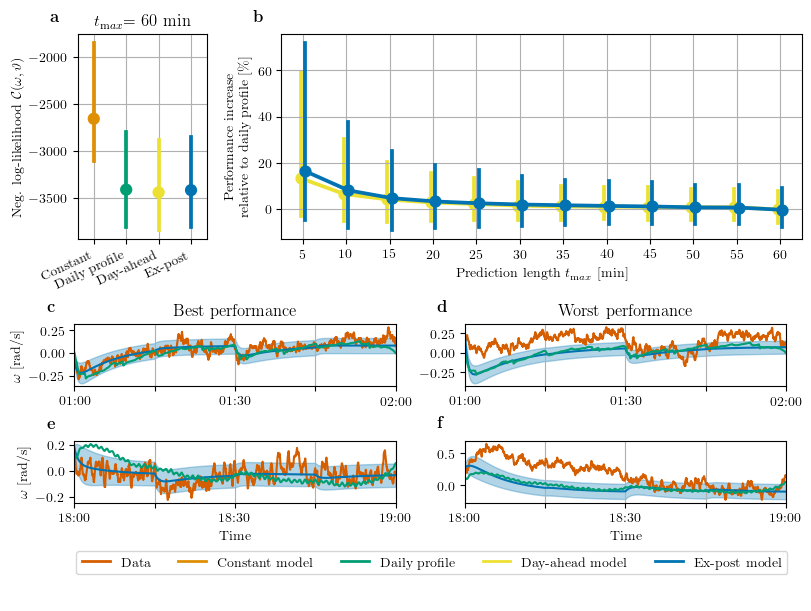

In [20]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)

gs = plt.GridSpec(3, 4, figure=fig,height_ratios=[0.9,1.1,0.05])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}', r'\textbf{g}', r'\textbf{h}',r'\textbf{i}']


#################
# absolute performance boxplot for whole interval

ax = fig.add_subplot(gs[0, 0])
data = perf_logl.loc[:,(slice(None),3600)]
data.columns= data.columns.droplevel(1)
sns.pointplot(data=data.rename(columns=model_display_names),estimator=np.median, 
            errorbar=('pi',50), ax=ax, palette=model_colors)
ax.set_title('$t_{\mathrm max}$= 60 min')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.text(0.0, 1.0, axs_labels[0], transform=ax.transAxes + trans,
        fontsize='large', va='bottom')
ax.set_ylabel(r'Neg. log-likelihood $\mathcal C(\omega, \vartheta)$')
ax.grid() 

#####################
# relative performance depending on tmax


ax = fig.add_subplot(gs[0, 1:])
data = perf_logl_diff.stack([0,1]).reset_index().rename(columns={'level_2':'tmax',
                                                                 'level_0':'time',
                                                                 'level_1':'model',
                                                                 0:'performance'})
data.loc[:,'tmax'] = (data.loc[:,'tmax']/60).astype(int)
sns.pointplot(data=data.replace(model_display_names),
            x="tmax", y="performance", hue="model",estimator=np.median, 
            errorbar=('pi', 50), ax=ax,
            palette=model_colors,  dodge=0.1)
plt.ylabel('Performance increase \nrelative to daily profile [\%]')
plt.xlabel('Prediction length $t_{\mathrm max}$ [min]')
ax.get_legend().remove()
ax.text(0.0, 1.0, axs_labels[1], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
#ax.axhline(0, color='gray', linewidth=1)
ax.grid()

#####################
# prediction examples

gs_sub = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,:])

for j, time_of_day in enumerate(['01:00', '18:00']):
    inds=[]
    inds+=[perf_logl.loc[:,('ex_post',3600)][perf_logl.index.strftime('%H:%M')==time_of_day].idxmin()]
    inds+=[perf_logl.loc[:,('ex_post',3600)][perf_logl.index.strftime('%H:%M')==time_of_day].idxmax()]
    
    for i,ind in enumerate(inds):
            
        ax = fig.add_subplot(gs_sub[j, i])    
        y_ml_pred_mean = model([dfs['X_test'].loc[[ind], cols], dfs['Z_test'].loc[[ind]]]).mean().numpy()[0]
        y_ml_pred_std = model([dfs['X_test'].loc[[ind], cols], dfs['Z_test'].loc[[ind]]]).stddev().numpy()[0]

        y_dp_pred_mean = dp_model(dfs['X_test'].loc[[ind]]).mean().numpy()[0]
        y_dp_pred_std = dp_model(dfs['X_test'].loc[[ind]]).stddev().numpy()[0]

        ts_plot = np.arange(3600)
        ax.plot(ts_plot, dfs['y_test'].loc[ind].values, label='data', c=c_data)
        ax.plot(ts_plot, y_ml_pred_mean, label='ML model', c=c_post)
        ax.fill_between(ts_plot, y_ml_pred_mean-y_ml_pred_std, y_ml_pred_mean+y_ml_pred_std, alpha=0.3,edgecolor=c_post, facecolor=c_post)
        ax.plot(ts_plot, y_dp_pred_mean, label='Daily profile', c=c_dp)
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.set_xticks([0,900,1800,2700,3600])
        ax.text(0.0, 1.0, axs_labels[2+j*2+i], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
        ax.grid(axis='x')
        
        if j==0:
            if i==0:
                ax.set_title('Best performance')  
                ax.set_ylabel('$\omega$ [rad/s]')         
            if i==1:
                ax.set_title('Worst performance')   
            ax.set_xticklabels(['01:00','','01:30','','02:00'])
        else:
            ax.set_xlabel('Time')
            ax.set_xticklabels(['18:00','','18:30','','19:00'])
            if i==0:
                ax.set_ylabel('$\omega$ [rad/s]')
    

legend_elements = [plt.Line2D([0], [0], color=c_data, lw=2, label='Data'),
                   plt.Line2D([0], [0], color=c_const, lw=2, label='Constant model'),
                   plt.Line2D([0], [0], color=c_dp, lw=2, label='Daily profile'),
                   plt.Line2D([0], [0], color=c_dh, lw=2, label='Day-ahead model'),
                   plt.Line2D([0], [0], color=c_post, lw=2, label='Ex-post model')
                   ]


#plt.tight_layout()

ax = fig.add_subplot(gs[2, :])
ax.set_axis_off()
ax.legend(handles=legend_elements, bbox_to_anchor=(.99,5, 0,0), ncol=5)

plt.savefig('./figures/fig2.pdf', bbox_inches='tight')


# Figure 3

In [6]:
model_name = 'ex_post'
cols = expost_cols

# re-load best model via tuner
with open(model_dir.format(model_name)+'fixed_model_hps.pkl', 'rb') as f:
    fixed_model_hps = pickle.load(f)
tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                directory=model_dir.format(model_name), oracle=kt.Oracle(),project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best HPs: ', best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.load_weights(model_dir.format(model_name)+'best_model/').expect_partial()

INFO:tensorflow:Reloading Tuner from ./results/CE/version_2023-05-03/ex_post/3600/tuning/tuner0.json
Best HPs:  {'lr': 0.001, 'dropout': 0.15, 'n_units': 128, 'n_layers': 3, 'activation_func': 'tanh'}


In [7]:
params = model.call_params(dfs['X_test'].loc[:,cols].values).numpy()
params_frame = pd.DataFrame(data=params, index=dfs['X_test'].index,
                            columns=model.st_process.param_names[2:])

p_daily_means = params_frame.groupby(params_frame.index.time).mean()
p_daily_std = params_frame.groupby(params_frame.index.time).std()
p_daily_q75 = params_frame.groupby(params_frame.index.time).quantile(0.75)
p_daily_q25 = params_frame.groupby(params_frame.index.time).quantile(0.25)

params_frame

,s_theta_0,cov_theta_omega_0,s_omega_0,tau,kappa,D,q1,q2,q3,q4,r
2019-03-14 05:00:00+01:00,74.345571,0.074271,0.001000,43.263740,146.281158,0.026113,0.005440,0.001568,0.000321,0.000723,-1.144179e-06
2019-08-30 06:00:00+02:00,51.880805,0.051830,0.001000,42.767881,118.053582,0.022674,0.009097,0.002190,0.000547,0.000525,-2.636172e-06
2019-08-22 10:00:00+02:00,52.671760,0.052568,0.001000,24.874241,128.909819,0.024213,-0.003668,-0.002456,-0.002890,-0.001410,4.184836e-06
2019-01-12 19:00:00+01:00,68.989891,0.067899,0.001000,36.517409,144.067955,0.021599,-0.004670,-0.002283,-0.002767,-0.001807,3.891540e-06
2019-09-12 08:00:00+02:00,58.832838,0.058775,0.001000,43.116741,127.850801,0.022056,0.004620,-0.001904,-0.000831,-0.000920,2.581973e-06
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-18 13:00:00+02:00,70.070595,0.069669,0.001000,24.750406,167.679924,0.025623,-0.004636,-0.001259,-0.004219,0.000282,3.408667e-06
2019-01-26 03:00:00+01:00,75.888553,0.029086,0.001000,30.240162,162.013186,0.022817,-0.008141,-0.000268,-0.003476,-0.000071,2.777315e-06
2019-01-18 09:00:00+01:00,44.234828,0.043449,0.001001,31.799085,123.425471,0.021033,-0.004345,-0.003356,-0.002717,-0.001422,1.730450e-06
2019-02-10 14:00:00+01:00,80.163204,0.075753,0.001000,29.556603,166.479719,0.022792,-0.005652,-0.000229,-0.002586,-0.000261,8.157842e-07


In [10]:
# Daily variations of the parameters
((p_daily_means.abs()-p_daily_means.abs().mean())/p_daily_means.abs().mean()).max()

s_theta_0            0.306590
cov_theta_omega_0    0.342360
s_omega_0            0.000331
tau                  0.373339
kappa                0.117218
D                    0.062608
q1                   0.800203
q2                   1.546842
q3                   1.094965
q4                   2.137658
r                    1.205602
dtype: float64

In [10]:
tau_ref = 120
kappa_ref = 183
D_ref = 0.007 
q1_ref = 0.010
q2_ref = 0.0017
q3_ref = 0.0034
q4_ref = 0.0017
r_ref=0.000009

In [11]:
# Predict with parameter model (this can take several minutes)

###### !!!!! Insert correct scalings !!!! ######

parameter_means = pd.DataFrame(columns=param_names+['kappa_scale', 'r_scale',
                                                    'q_scale','D_scale',
                                                    'performance','n_epochs',
                                                    'property', 'seed'])

i=0
for init_seed in tqdm(range(10)):
    for kappa_scale in [100,1000]:
        for r_scale in [1e-6,1e-5]:
            for q_scale in [1e-3,1e-2]:
                for D_scale in [0.01,0.1]: 

                
                    scaling_model_name = 'best_model_kappa{}_q{}_r{}_D{}_seed{}/'.format(kappa_scale,q_scale, r_scale,D_scale, init_seed)
                
                    pscalings = tf.constant([1,np.nan,0.1,
                                                        np.nan,kappa_scale,
                                                        D_scale,q_scale,q_scale,q_scale,q_scale, r_scale],
                                                        dtype=custom_dtype)
                    n_epochs = np.loadtxt(model_dir.format(model_name)+scaling_model_name+'n_epochs.txt')
                    tuner.hypermodel.param_scalings=pscalings
                    model = tuner.hypermodel.build(best_hps)
                    model.load_weights(model_dir.format(model_name)+scaling_model_name).expect_partial() 
                    params = model.call_params(dfs['X_test'].loc[:,cols].values).numpy()
                    parameter_means.loc[i, param_names] = np.abs(params).mean(0)
                    parameter_means.loc[i,'kappa_scale' ]= kappa_scale
                    parameter_means.loc[i,'r_scale' ]= r_scale
                    parameter_means.loc[i,'q_scale' ]= q_scale
                    parameter_means.loc[i,'D_scale' ]= D_scale
                    # parameter_means.loc[i,'performance' ]= np.mean(negloglik(dfs['y_test'],
                    #                                                         model([dfs['X_test'].loc[:,cols],dfs['Z_test']])))
                    
                    parameter_means.loc[i,'n_epochs'] = n_epochs
                    parameter_means.loc[i,'seed'] = init_seed

                    if np.allclose(pscalings.numpy(), [1,np.nan,0.1,np.nan,100,0.01,0.001,0.001,0.001,0.001, 0.000001], equal_nan=True):
                        parameter_means.loc[i,'property'] = 'main_model'
                    else:
                        parameter_means.loc[i,'property'] = 'scaling_variation'

                    i+=1



    #no scaling model
    scaling_model_name = 'best_model_no_scaling_seed{}/'.format(init_seed)

    pscalings = tf.constant([1,np.nan,1,np.nan,1,1,1,1,1,1, 1],
                            dtype=custom_dtype)
    n_epochs = np.loadtxt(model_dir.format(model_name)+scaling_model_name+'n_epochs.txt')
    tuner.hypermodel.param_scalings=pscalings
    model = tuner.hypermodel.build(best_hps)
    model.load_weights(model_dir.format(model_name)+scaling_model_name).expect_partial() 
    params = model.call_params(dfs['X_test'].loc[:,cols].values).numpy()
    parameter_means.loc[i, param_names] = np.abs(params).mean(0)
    parameter_means.loc[i,'kappa_scale' ]= 1
    parameter_means.loc[i,'r_scale' ]= 1
    parameter_means.loc[i,'q_scale' ]= 1
    parameter_means.loc[i,'D_scale' ]= 1
    # parameter_means.loc[i,'performance' ]= np.mean(negloglik(dfs['y_test'],
    #                                                         model([dfs['X_test'].loc[:,cols],dfs['Z_test']])))
    parameter_means.loc[i,'n_epochs'] = n_epochs             
    parameter_means.loc[i,'property'] = 'no_scaling'    
    parameter_means.loc[i,'seed'] = init_seed
    
    i+=1   
        
# Reference results
parameter_means.loc[i+1, param_names[3:]] = [tau_ref, kappa_ref, D_ref, q1_ref, q2_ref, q3_ref, q4_ref, r_ref]
parameter_means.loc[i+1,'property'] = 'literature'   

parameter_means


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


,s_theta_0,cov_theta_omega_0,s_omega_0,tau,kappa,D,q1,q2,q3,q4,r,kappa_scale,r_scale,q_scale,D_scale,performance,n_epochs,property,seed
0,59.806172,0.057554,0.001002,31.431793,141.95164,0.025396,0.006457,0.00113,0.002924,0.00043,0.000004,100,0.000001,0.001,0.01,NaN,69.0,main_model,0
1,53.576162,0.050137,0.001001,37.807393,148.619987,0.023553,0.005727,0.000962,0.002362,0.00037,0.000003,100,0.000001,0.001,0.1,NaN,37.0,scaling_variation,0
2,69.899026,0.059504,0.001001,22.537899,125.377405,0.02879,0.008797,0.001406,0.003591,0.000741,0.000005,100,0.000001,0.01,0.01,NaN,86.0,scaling_variation,0
3,55.051078,0.047622,0.001002,14.584011,98.429367,0.038422,0.014434,0.002344,0.006186,0.001399,0.000008,100,0.000001,0.01,0.1,NaN,45.0,scaling_variation,0
4,66.074145,0.064144,0.001001,26.539552,133.732759,0.027642,0.008023,0.001335,0.00347,0.000627,0.000004,100,0.00001,0.001,0.01,NaN,84.0,scaling_variation,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,68.26758,0.065767,0.001,10.765741,97.994556,0.04284,0.017815,0.002493,0.008087,0.001676,0.000011,1000,0.00001,0.001,0.1,NaN,56.0,scaling_variation,9
167,8.940472,1.090104,0.108479,22.539221,88.47169,0.034615,0.006556,0.001594,0.003399,0.001008,0.000004,1000,0.00001,0.01,0.01,NaN,30.0,scaling_variation,9
168,66.716283,0.061472,0.001,10.479424,91.119898,0.043447,0.019648,0.002661,0.008432,0.001945,0.000011,1000,0.00001,0.01,0.1,NaN,72.0,scaling_variation,9
169,0.715155,0.191658,0.488029,14.657525,30.092188,6.302189,0.208505,0.339466,0.387077,0.240486,0.022647,1,1,1,1,NaN,25.0,no_scaling,9


In [12]:
# relative to literature values
relative_parameter_means = parameter_means.copy()[parameter_means.property!='literature']     
relative_parameter_means.loc[:, param_names] /= parameter_means[parameter_means.property=='literature'].loc[:, param_names].values

relative_parameter_means

,s_theta_0,cov_theta_omega_0,s_omega_0,tau,kappa,D,q1,q2,q3,q4,r,kappa_scale,r_scale,q_scale,D_scale,performance,n_epochs,property,seed
0,NaN,NaN,NaN,0.261932,0.775692,3.628003,0.645709,0.664853,0.860079,0.252726,0.426497,100,0.000001,0.001,0.01,NaN,69.0,main_model,0
1,NaN,NaN,NaN,0.315062,0.812131,3.364669,0.572666,0.56591,0.69457,0.217438,0.367805,100,0.000001,0.001,0.1,NaN,37.0,scaling_variation,0
2,NaN,NaN,NaN,0.187816,0.685122,4.112812,0.879655,0.827068,1.056238,0.435614,0.561397,100,0.000001,0.01,0.01,NaN,86.0,scaling_variation,0
3,NaN,NaN,NaN,0.121533,0.537865,5.488826,1.443412,1.378765,1.819546,0.822943,0.918949,100,0.000001,0.01,0.1,NaN,45.0,scaling_variation,0
4,NaN,NaN,NaN,0.221163,0.73078,3.948889,0.802347,0.785358,1.020591,0.368961,0.497356,100,0.00001,0.001,0.01,NaN,84.0,scaling_variation,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,NaN,NaN,NaN,0.285931,0.820039,3.504099,0.571951,0.570993,0.811173,0.273196,0.363388,1000,0.00001,0.001,0.01,NaN,89.0,scaling_variation,9
166,NaN,NaN,NaN,0.089715,0.535489,6.119939,1.781497,1.466581,2.378612,0.986071,1.237965,1000,0.00001,0.001,0.1,NaN,56.0,scaling_variation,9
167,NaN,NaN,NaN,0.187827,0.483452,4.944978,0.655575,0.937915,0.999845,0.593126,0.4783,1000,0.00001,0.01,0.01,NaN,30.0,scaling_variation,9
168,NaN,NaN,NaN,0.087329,0.497923,6.206763,1.964821,1.565005,2.479861,1.144402,1.250411,1000,0.00001,0.01,0.1,NaN,72.0,scaling_variation,9


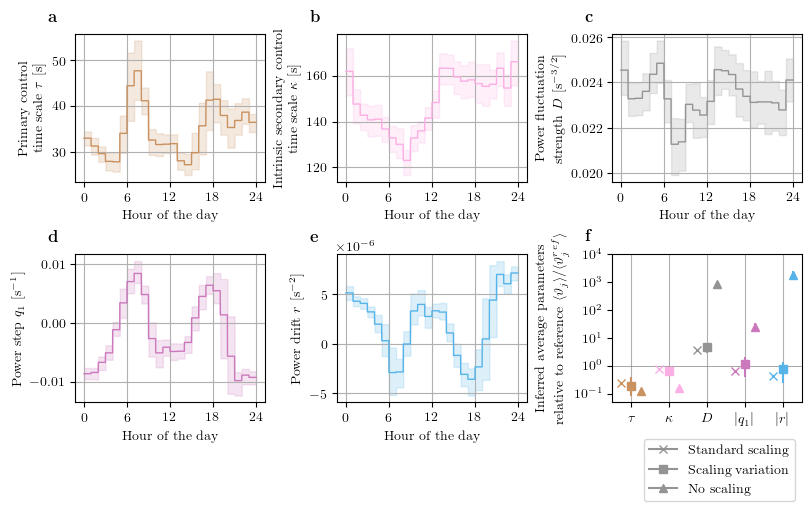

In [23]:
fig = plt.figure(figsize=(8,5.),constrained_layout=True)

gs = plt.GridSpec(2, 3, figure=fig)#,height_ratios=[1,1])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}']#, r'\textbf{h}',r'\textbf{i}']


######################
# daily profiles of parameters

n_interval_per_hour = 1 


for i,name in enumerate(param_names_short[3:]):
    
    ax = fig.add_subplot(gs[i//3,i%3])
    ax.plot(np.arange(0,24,1/60)/n_interval_per_hour,
            p_daily_means.reset_index().reindex(np.arange(0,24,1/60)).ffill().loc[:,name].values*param_rescaling[name],
            c=param_colors[name], lw=1)
    ax.fill_between(np.arange(0,24,1/60)/n_interval_per_hour,
                    p_daily_q25.reset_index().reindex(np.arange(0,24,1/60)).ffill().loc[:,name].values*param_rescaling[name],
                    p_daily_q75.reset_index().reindex(np.arange(0,24,1/60)).ffill().loc[:,name].values*param_rescaling[name],
                    alpha=0.2, edgecolor=param_colors[name], facecolor=param_colors[name])
    ax.set_ylabel(param_display_names_units[name])
    ax.grid()
    ax.text(0.0, 1.0, axs_labels[i], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
    ax.set_xticks([0,6,12,18,24])
    ax.set_xlabel('Hour of the day')


#####################
# variation of scaling experiment

ax = fig.add_subplot(gs[1,2])

for i, prop in enumerate(['main_model', 'scaling_variation', 'no_scaling']):
        for j, param in enumerate(param_names_short[3:]):
                mean_val = relative_parameter_means[relative_parameter_means.property==prop].loc[:,param].abs().mean()
                min_val = relative_parameter_means[relative_parameter_means.property==prop].loc[:,param].abs().min()
                max_val = relative_parameter_means[relative_parameter_means.property==prop].loc[:,param].abs().max()
                
                ax.errorbar(x=j+(i-1)/3.7,y=mean_val, yerr=np.array([[mean_val-min_val],[max_val-mean_val]]),
                            fmt=['x','s', '^'][i], ecolor=param_colors[param], c=param_colors[param], ms=6)


ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([param_display_names_abs[param] for param in param_names_short[3:]])
ax.set_yscale('log')
ax.set_yticks([1e-1,1e0,1e1,1e2,1e3, 1e4])
ax.set_ylabel('Inferred average parameters \nrelative to reference '+ r'$\langle \vartheta_j \rangle / \langle \vartheta_j^{ref} \rangle$')
ax.text(0.0, 1.0, axs_labels[-1], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
ax.grid(axis='x')
ax.axhline(1, color='gray', linewidth=0.5)

legend_elements = [plt.Line2D([0], [0], marker='x', color=c_D, label='Standard scaling', markersize=6),
                   plt.Line2D([0], [0], marker='s', color=c_D, label='Scaling variation', markersize=6),
                   plt.Line2D([0], [0], marker='^', color=c_D, label='No scaling', markersize=6)
                   ]

# Create the figure
ax.legend(handles=legend_elements, bbox_to_anchor=(1,-0.2,0,0), ncol=1)

plt.savefig('./figures/fig3.pdf', bbox_inches='tight')


# Figure 4

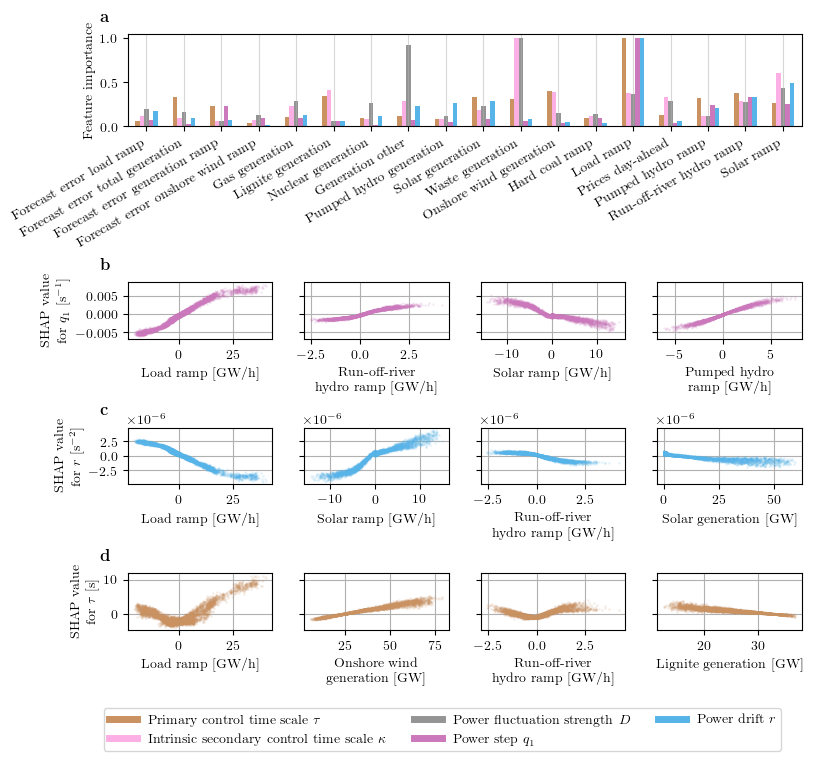

In [26]:
model_name = 'ex_post'
cols = expost_cols

fig = plt.figure(figsize=(8,7.5),constrained_layout=True)

gs = plt.GridSpec(5, 4, figure=fig,height_ratios=[1.3,0.8,0.8,0.8,0.1])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}', r'\textbf{g}' ,
              r'\textbf{h}',r'\textbf{i}',r'\textbf{j}',r'\textbf{k}', r'\textbf{l}', r'\textbf{m}']

# Number of most important features included from each parameter
n_features= 8

# selected features for dependency plots 
# 4 most important, without hour/minute features and double features due to actual/day-ahead removed


##########################
# Feature importances

ax = fig.add_subplot(gs[0, :])

# Setup
shap_vals_abs=pd.DataFrame(index=cols, columns=param_names_short[3:])
shap_vals_max=pd.DataFrame(index=cols, columns=param_names_short[3:])
important_features = []

# Create set of unique important features 
for i,param in enumerate(param_names_short[3:]):      
    shap_vals=pd.read_hdf(model_dir.format(model_name)+'shap_values_{}_long.h5'.format(param))
    important_features+= list(shap_vals.abs().median().sort_values(ascending=False).iloc[:n_features].index)
    shap_vals_abs.loc[:,param] = shap_vals.abs().median()
    shap_vals_max.loc[:,param] = shap_vals.abs().max()
        
important_features = np.unique(important_features)
shap_vals_abs = shap_vals_abs / shap_vals_abs.max()
shap_vals_abs = shap_vals_abs.loc[important_features]

# make feature importance bar plots
g= sns.barplot(data=shap_vals_abs.rename(index=input_col_names).unstack().reset_index(),
            x='level_1',y=0,hue='level_0',ax=ax,
            palette=param_colors, saturation=1, width=0.6)
g.legend_.remove()


# add axis labels and legend
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_xlabel('')
ax.set_ylabel('Feature importance')
legend_elements = [plt.Line2D([0], [0], color=par_color, lw=5, label=label) for par_color, label in zip(param_colors.values(),
                                                                                                        param_display_names.values())
                   ]

   
# add target names    
ax.grid(True, axis='x', alpha=0.5)
ax.text(0.0, 1.0, axs_labels[0], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

##########################
# Dependency plots

features_to_plot = {'q1':shap_vals_abs.loc[:,'q1'].sort_values().iloc[::-1].head(4).index,
                    'r':shap_vals_abs.loc[:,'r'].sort_values().iloc[::-1].head(4).index,
                    'tau':shap_vals_abs.loc[:,'tau'].sort_values().iloc[::-1].head(4).index
                    }


for i, (param, feature_list) in enumerate(features_to_plot.items()):

    shap_vals=pd.read_hdf(model_dir.format(model_name)+'shap_values_{}_long.h5'.format(param))
    X_data = dfs['X_test'].loc[shap_vals.index, cols]
    
    for j,feature in enumerate(feature_list):
        
        if feature!='':
            
            if j==0:
                ax = fig.add_subplot(gs[1+i, j]) 
            else:
                ax = fig.add_subplot(gs[1+i, j],sharey=ax_old)
                plt.setp(ax.get_yticklabels(), visible=False)   
            ax.plot(X_data.mul(input_rescale_factors).loc[:,feature],
                    shap_vals.loc[:, feature]*param_rescaling[param], '.',
                    rasterized=True, c=param_colors[param], ms=2, alpha=0.1)
            ax.set_xlabel(input_col_names_units[feature])
            ax.grid()
            
            
            if j==0:
                ax.set_ylabel('SHAP value \nfor {}'.format(param_display_names_short[param]))
                ax.text(0.0, 1.0, axs_labels[1+i], transform=ax.transAxes + trans,
                        fontsize='large', va='bottom')
            ax_old = ax
        

###########################

ax = fig.add_subplot(gs[-1, :]) 
ax.set_axis_off()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.98,0), ncol=3, fontsize=10,columnspacing=2)

plt.savefig('./figures/fig4.pdf', bbox_inches='tight')


# Figure 5

In [27]:
model_name = 'ex_post'
cols = expost_cols

# re-load best model via tuner
with open(model_dir.format(model_name)+'fixed_model_hps.pkl', 'rb') as f:
    fixed_model_hps = pickle.load(f)
tuner=kt.Tuner(hypermodel=SOHyperModel(**fixed_model_hps, loss=negloglik),
                directory=model_dir.format(model_name), oracle=kt.Oracle(),project_name="tuning")
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.load_weights(model_dir.format(model_name)+'best_model/').expect_partial()

INFO:tensorflow:Reloading Tuner from ./results/CE/version_2023-05-03/ex_post/3600/tuning/tuner0.json
{'lr': 0.001, 'dropout': 0.15, 'n_units': 128, 'n_layers': 3, 'activation_func': 'tanh'}


<AxesSubplot:>

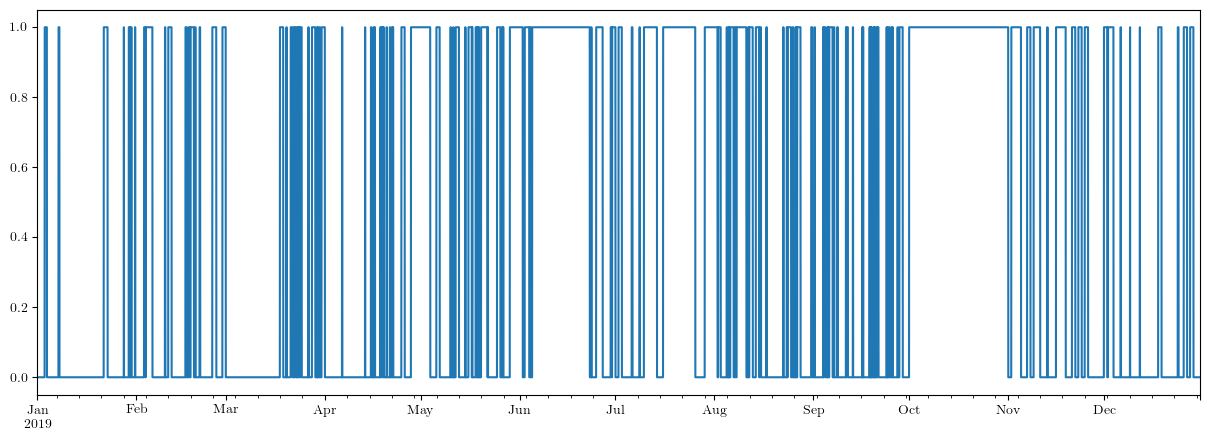

In [28]:
# plot intervals with nans
full_rolling_index = pd.date_range(start=dfs['y_test'].sort_index().index[0],end=dfs['y_test'].sort_index().index[-1], freq='1h')
dfs['y_test'].reindex(full_rolling_index).isnull().any(1).astype(int).plot(figsize=(15,5))

In [29]:
# find largest non-nan interval

def true_intervals(bool_arr):
    """ Get intervals where bool_arr is true"""

    mask = np.concatenate([[True], ~bool_arr, [True]])
    interval_bounds = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1, 2)
    interval_sizes = interval_bounds[:, 1] - interval_bounds[:, 0]

    return interval_bounds, interval_sizes

full_rolling_index = pd.date_range(start=dfs['y_test'].sort_index().index[0],end=dfs['y_test'].sort_index().index[-1], freq='1h')
valid_bounds, valid_sizes = true_intervals(~dfs['y_test'].reindex(full_rolling_index).isnull().any(1).values)
start,end= valid_bounds[ np.argsort(valid_sizes)[-3] ] 
# -1 and -2 contain singluar events such as long-lasting power imbalances and are therefore not suitable for comparison
full_rolling_test_index = dfs['y_test'].reindex(full_rolling_index).iloc[start:end].index

full_rolling_test_index


DatetimeIndex(['2019-04-06 12:00:00+02:00', '2019-04-06 13:00:00+02:00',
               '2019-04-06 14:00:00+02:00', '2019-04-06 15:00:00+02:00',
               '2019-04-06 16:00:00+02:00', '2019-04-06 17:00:00+02:00',
               '2019-04-06 18:00:00+02:00', '2019-04-06 19:00:00+02:00',
               '2019-04-06 20:00:00+02:00', '2019-04-06 21:00:00+02:00',
               ...
               '2019-04-13 05:00:00+02:00', '2019-04-13 06:00:00+02:00',
               '2019-04-13 07:00:00+02:00', '2019-04-13 08:00:00+02:00',
               '2019-04-13 09:00:00+02:00', '2019-04-13 10:00:00+02:00',
               '2019-04-13 11:00:00+02:00', '2019-04-13 12:00:00+02:00',
               '2019-04-13 13:00:00+02:00', '2019-04-13 14:00:00+02:00'],
              dtype='datetime64[ns, CET]', length=171, freq='H')

In [30]:
# Construct rolling scenario for largest interval

X_rolling = dfs['X_test'].loc[:,cols].reindex(index=full_rolling_test_index)
Z_rolling = dfs['Z_test'].reindex(index=full_rolling_test_index)
y_rolling = dfs['y_test'].reindex(index=full_rolling_test_index)
print(X_rolling.isnull().any(1).sum())


0


In [32]:
n_scenarios = 1
y_ml_pred_series_rolling = dict(keys=range(n_scenarios))
for i in range(n_scenarios):
    print(i)
    np.random.seed(100+i)
    y_ml_pred_series_rolling[i] = pd.DataFrame(index=X_rolling.index,
                                               data=model.generate_sample([X_rolling, Z_rolling],
                                                                          rolling=True)).sort_index()

y_ml_pred_series_rolling


0


100%|██████████| 171/171 [02:24<00:00,  1.18it/s]


{'keys': range(0, 1),
 0:                                0         1         2         3         4     \
 2019-04-06 12:00:00+02:00  0.100531  0.093087  0.081239  0.111152  0.069828   
 2019-04-06 13:00:00+02:00  0.099408  0.095971  0.095507  0.140229  0.143628   
 2019-04-06 14:00:00+02:00  0.210274  0.219395  0.225910  0.232758  0.207343   
 2019-04-06 15:00:00+02:00  0.085346  0.078072  0.061185  0.096781  0.054857   
 2019-04-06 16:00:00+02:00 -0.097016 -0.087325 -0.089520 -0.081490 -0.051015   
 ...                             ...       ...       ...       ...       ...   
 2019-04-13 10:00:00+02:00  0.026885 -0.017947  0.004847 -0.021706 -0.029023   
 2019-04-13 11:00:00+02:00  0.131681  0.090757  0.066482  0.030845  0.031644   
 2019-04-13 12:00:00+02:00  0.043905  0.046658  0.034657  0.031765  0.023157   
 2019-04-13 13:00:00+02:00  0.028165  0.040346  0.024880  0.004381 -0.056740   
 2019-04-13 14:00:00+02:00  0.181761  0.144583  0.120449  0.092948  0.120857   
 
             

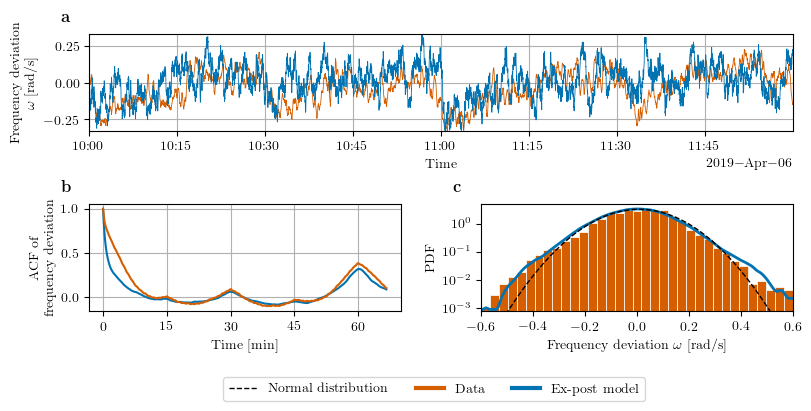

In [65]:
fig = plt.figure(figsize=(8,4),constrained_layout=True)

gs = plt.GridSpec(3, 2, figure=fig,height_ratios=[1,1.1, 0.1])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',r'\textbf{e}', r'\textbf{f}', r'\textbf{g}' ]#, r'\textbf{h}',r'\textbf{i}']

############
# time series examples

ax = fig.add_subplot(gs[0, :])
n_hours = 2
for i in range(n_scenarios):
    plot_ind = pd.date_range(start=y_ml_pred_series_rolling[i].index[0],
                            end=y_ml_pred_series_rolling[i].index[n_hours],
                            freq='1s')[:-1]
    ax.plot(plot_ind, y_rolling.iloc[:n_hours].values.flatten(), label='data', lw=0.6, c=c_data)
    ax.plot(plot_ind, y_ml_pred_series_rolling[i].iloc[:n_hours].values.flatten(), label='model (rolling)', lw=0.6, c=c_post)
ax.grid()
ax.set_xlim([plot_ind[0],plot_ind[-1]])
max_val = np.amax(y_rolling.iloc[:n_hours].abs().values.flatten())
ax.set_ylim([-max_val,max_val])
ax.set_xlabel('Time')
ax.set_ylabel('Frequency deviation \n$\omega$ [rad/s]')
ax.text(0.0, 1.0, axs_labels[0], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


############
# ACF

ax = fig.add_subplot(gs[1, 0])
for i in range(n_scenarios):
    acf_all = sm.tsa.acf(y_ml_pred_series_rolling[i].values.flatten(), missing='raise', nlags=4000)
    acf_data=sm.tsa.acf(y_rolling.sort_index().values.flatten(), missing='conservative', nlags=4000)
    ax.plot(acf_all, label='using model sample (rolling)', c=c_post)
    ax.plot(acf_data, label='from data', c=c_data)
ax.set_ylabel('ACF of \nfrequency deviation')
ax.set_xticks([0,900,1800,2700,3600])
ax.set_xticklabels([0,15,30,45,60])
ax.set_xlabel('Time [min]')
ax.text(0.0, 1.0, axs_labels[1], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')
ax.grid()

############
# freq hist

ax = fig.add_subplot(gs[1, 1])
binrange=[-0.6,0.6]

sns.histplot(data=y_rolling.values.flatten(), log_scale=(False,True),ax=ax,bins=35, label='from data',
             stat='density', element='bars', facecolor=c_data, edgecolor='white', binrange=binrange)
for i in range(n_scenarios):
    sns.kdeplot(data=y_ml_pred_series_rolling[i].values.flatten(), log_scale=(False,True),ax=ax,
                label='from sample', color=c_post, lw=2)


mu, std = scipy.stats.norm.fit(y_rolling.values.flatten())
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
ax.plot(x, p,'--', c='black', linewidth=1)

ax.set_xlim(binrange)
ax.set_ylim([8e-4,5e0])
ax.set_yticks([1e0,1e-1,1e-2, 1e-3])
ax.set_xlabel('Frequency deviation $\omega$ [rad/s]')
ax.set_ylabel('PDF')


ax.text(0.0, 1.0, axs_labels[2], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')


legend_elements = [plt.Line2D([0], [0], color='black', lw=1, linestyle='--', label='Normal distribution'),
                   plt.Line2D([0], [0], color=c_data, lw=3, label='Data'),
                   plt.Line2D([0], [0], color=c_post, lw=3, label='Ex-post model')
                   ]
ax = fig.add_subplot(gs[2, :])
ax.set_axis_off()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.8,0, 0,0), ncol=5)

plt.savefig('./figures/fig5.pdf', bbox_inches='tight')


# Figure 6

In [ ]:
fig = plt.figure(figsize=(8,3),constrained_layout=True)

gs = plt.GridSpec(2, 2, figure=fig,height_ratios=[1,0.05])
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
axs_labels = [r'\textbf{a}', r'\textbf{b}']

######## Increment histogram #########

ax = fig.add_subplot(gs[0,0])
lag = 1
data = y_rolling.values.flatten()
binrange = [-0.1, 0.1]
sns.histplot(data=data[lag:]-data[:-lag], log_scale=(False,True),ax=ax,bins=30, label='from data',
             stat='density', element='bars', facecolor=c_data, edgecolor='white', binrange=binrange)

data = y_ml_pred_series_rolling[0].values.flatten()
sns.kdeplot(data=data[lag:]-data[:-lag], log_scale=(False,True),ax=ax, label='from sample', color=c_post, lw=2)


data = y_rolling.values.flatten()
mu, std = scipy.stats.norm.fit(data=data[lag:]-data[:-lag])
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
l0,=ax.plot(x, p,'--', c='black', linewidth=1)

ax.set_xlim(binrange)
ax.set_ylim([5e-4,1e2])
ax.set_xlabel(r'Increment $\Delta \omega_{T}$ [rad/s]')
ax.set_ylabel('PDF')
ax.set_title('Increment lag $T=1$ s')
ax.text(0.0, 1.0, axs_labels[0], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

######### ACF of increments ##########

ax = fig.add_subplot(gs[0,1])
for lag, style in zip([1,60],['-','--']):
    data = y_ml_pred_series_rolling[0].values.flatten()
    data=data[lag:]-data[:-lag]
    acf_all = sm.tsa.acf(data, missing='conservative', nlags=20)
    
    data = y_rolling.sort_index().values.flatten()
    data=data[lag:]-data[:-lag]
    acf_data=sm.tsa.acf(data, missing='conservative', nlags=20)
    
    ax.plot(acf_all,  c=c_post, ls=style)
    ax.plot(acf_data, c=c_data, ls=style)
ax.set_ylabel('ACF of increments')
ax.grid()
ax.set_ylim([-0.2,1.2])
ax.set_xticks([0,1,5,10,15,20])
ax.set_xticklabels([0,1,5,10,15,20])
ax.set_xlabel('Time [s]')
ax.text(0.0, 1.0, axs_labels[1], transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

legend_elements = [plt.Line2D([0], [0], color='black', lw=1, linestyle='-', label='1 s'),
                   plt.Line2D([0], [0], color='black', lw=1, linestyle='--', label='60 s'), 
                   ]
ax.legend(handles=legend_elements, title='Increment lag $T$')


#############################

legend_elements = [plt.Line2D([0], [0], color=c_data, lw=1, linestyle='-', label='Data'),
                   plt.Line2D([0], [0], color=c_post, lw=1, linestyle='-', label='Ex-post model'), 
                   ]
ax = fig.add_subplot(gs[1, :])
ax.set_axis_off()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.7,0, 0,0), ncol=5)
ax.grid()


plt.savefig('./figures/fig6.pdf', bbox_inches='tight')
